# Interactive dEB light curve "quick" fitting tool

In [1]:
# A vain attempt to suppress excessive TF info/warn messages
%env TF_CPP_MIN_LOG_LEVEL 2

env: TF_CPP_MIN_LOG_LEVEL=2


In [2]:
import sys
from pathlib import Path
import re
from ast import literal_eval
import warnings
from multiprocessing import Pool

import numpy as np
from scipy.interpolate import RegularGridInterpolator
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle, Distance
from mocpy import MOC
from astroquery.vizier import Vizier
from astroquery.simbad import Simbad
import lightkurve as lk
from uncertainties import UFloat, ufloat

#%matplotlib widget 
import matplotlib.pyplot as plt

# Support for interactive widgets
from IPython.display import *
from ipywidgets import *
from ipyaladin import Aladin, Marker

# Dereddening of SEDS
from dust_extinction.parameter_averages import G23

# MCMC for SEDS
import emcee
from emcee.autocorr import AutocorrError
import corner

from deblib import limb_darkening
from deblib.constants import c
from ebop_maven.estimator import Estimator
from libs import lightcurves, pipeline, plots, jktebop, mcmc_sed, extinction
from libs.mistisochrones import MistIsochrones, Phase
from libs.sed import get_sed_for_target, calculate_vfv

/home/steveo/projects/main/platodebcat/.platodebcat/lib/python3.11/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
2025-06-27 10:03:39.983940: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751015019.996260    9947 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751015019.999746    9947 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751015020.009132    9947 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once

<img src="https://www.aanda.org/articles/aa/full_html/2025/02/aa52325-24/aa52325-24-fig3.jpg" alt="Image by Nascimbeni et al. (2025)" width="750"/>

The PLATO LOPS2 long-pointing field as defined by [Nascimbeni et al. (2025)](https://ui.adsabs.harvard.edu/abs/2025A&A...694A.313N) with the HEALPix grids published at [zenodo](https://zenodo.org/records/14720127). 

In [3]:
# MOC (multi-order coverage map) for querying the full LOPS2 field (regardless of the ncam coverage)
lops_moc = MOC.load(path="libs/data/lops2-footprints-moc/PLATOfootprint_hpix9_full_v2.fits")

In [4]:
tess_ebs_catalog = Vizier(catalog="J/ApJS/258/16", row_limit=1)
gaia_tbosb_catalog = Vizier(catalog="I/357/tbosb2", row_limit=1)
estimator = Estimator()

E0000 00:00:1751015021.227093    9947 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1751015021.227458    9947 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Estimator loading '/home/steveo/projects/main/platodebcat/.platodebcat/lib/python3.11/site-packages/ebop_maven/data/estimator/default-model.keras'...loaded 'CNN-New-Ext0-bP-4096-None-500k'.
The model CNN-New-Ext0-bP-4096-None-500k was created at 2025-02-17T20:48:17+00:00
The input features are:
  mags_feature as a NDarray[float] of shape (#instances, 4096) containing a phase folded light curve centred on the mid-point between the primary and secondary eclipse
  extra_features as a NDarray of shape (#instances, 0) or None, as no extra_features are used for predictions
The prediction results are:
  predicted values as a structured NDarray[UFloat] of shape (#instances, [rA_plus_rB, k, J, ecosw, esinw, bP])
  optionally, if include_raw is True, all MC predictions as a NDArray[float] of shape (#instances, 6, #iterations)


### Select the target 
You can select from the TESS-ebs targets within the LOPS2 field or specify your own target.

The target is the object name value used on plots, messages and local cache folder.
The search term is used to search for assets in MAST, which can be the target name
(with or without a V* prefix) or a TIC identifier (9 digit numeric value). The exposure time
constrains the results by the cadence of the observations recorded. For more details see the 
[lightkurve documentation](https://lightkurve.github.io/lightkurve/reference/api/lightkurve.search_lightcurve.html).

In [5]:
tebs_lops = lops_moc.query_vizier_table("J/ApJS/258/16")
print(f"Found {len(tebs_lops)} target(s) from the TESS-ebs catalog in the LOPS2 field")

_tebs_opts = [(f"{t['TIC']} (Morph={t['Morph']:.3f}; Per={t['Per']:.3f} d)", t['TIC'])
                for t in tebs_lops[(tebs_lops["Morph"] < 0.5) & (tebs_lops["Per"] > 2.0) & (tebs_lops["Per"] < 28.0)]]
_exptime_opts = [("any", None), ("fast (20 s)", "fast"), ("short (60 or 120 s)", "short"), ("long (>= 10 min)", "long")]
display(VBox(children=[
    HBox(children=[
        (_tebs_targs := Dropdown(description="TESS-ebs :", options=_tebs_opts, value="0201497357", layout={'width': "max-content"})),
        (exptime_opt := Dropdown(description="Exposure :", value="short", options=_exptime_opts)),
    ]),
    HBox(children=[
        (target_text := Text(description="target :", value="", placeholder="name or TIC")),
        (do_prefix := Checkbox(description="prefix non-numeric search term with V*", value=True, layout={'width': "max-content"} )),
    ]),
]))

dl = dlink((_tebs_targs, 'value'), (target_text, 'value'))

Found 556 target(s) from the TESS-ebs catalog in the LOPS2 field


### Review Target Information and refine the search

In [6]:
target = f"TIC {int(target_text.value):d}" if target_text.value.isnumeric() else target_text.value
search_term = f"V* {target}" if not target.startswith("TIC") and do_prefix.value else target
print(f"The chosen target is '{target}' with search_term '{search_term}'")

simbad = Simbad()
target_coords = None
if _tbl := simbad.query_objectids(search_term): # Table with single id column
    _ids = sorted(i for i in _tbl["id"] if i.startswith(("V*","H","TIC","Gaia DR3")) and i != search_term)
    print("AKA:       ", ", ".join(_ids))

simbad.add_votable_fields("parallax", "allfluxes", "sp_type")
if _tbl := simbad.query_object(search_term):
    target_coords = SkyCoord(ra=_tbl["ra"][0] * _tbl["ra"].unit,
                             dec=_tbl["dec"][0] * _tbl["dec"].unit,
                             distance=1000 / _tbl["plx_value"][0] * u.pc)
    print(f"Coords:    ", f"{target_coords}".replace("\n", ""))
    print(f"SpT:       ", f"{_tbl['sp_type'][0]}")

if _tbl := gaia_tbosb_catalog.query_object(search_term, radius=0.1 * u.arcmin):
    for row in _tbl:
        print(f"Gaia TBOSB: period={row['Per'][0]:.6f} d, ecc={row['ecc'][0]:.6f},",
              f"omega={row['omega'][0]:.6f}, K1={row['K1'][0]:.6f}, K2={row['K2'][0]:.6f}")

The chosen target is 'TIC 201497357' with search_term 'TIC 201497357'


AKA:        Gaia DR3 2896304530269262976, HD  42968, HIC  29455, HIP 29455, V* IO CMa
Coords:     <SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)    (93.09354251, -30.48150619, 175.30634784)>
SpT:        A1mA5-F2


In [7]:
aview = Aladin(fov=1.0, reticle_size=64)
if target_coords:
    aview.target = target_coords
aview # Doesn't display if within an if or try block!

Aladin()

In [8]:
search_results = lk.search_lightcurve(search_term, exptime=exptime_opt.value)
suitable_mask = ((search_results.author == "SPOC") | (search_results.author == "TESS-SPOC")) \
                    & (search_results.table["dataproduct_type"] == "timeseries") \
                    & np.where(["TESS" in m for m in search_results.mission], True, False)

# Give use chance to select/deselect sectors and set the flux column and quality bitmask
target_box = Accordion(children=[
    VBox(children=(sec_checks := 
        [Checkbox(description="toggle all", value=True, indent=False)] + 
        [Checkbox(description=f"{r.mission[0]} ({r.year[0]}): author={r.author[0]}, target={r.target_name[0]}, exptime={r.exptime[0]}",
                  value=True, indent=False, layout={'width': "max-content"}) for r in search_results[suitable_mask]]
    )),
    HBox(children=[
        (flux_column := widgets.Dropdown(description="flux_column :", options=["sap_flux", "pdcsap_flux"], value="sap_flux", style={'description_width': 'max-content'})),
        (quality_bitmask := widgets.Dropdown(description="quality_bitmask :", options=["default", "hard", "hardest"], value="hardest", style={'description_width': 'max-content'})),
    ])
], titles=[f"Sectors found for {target}", "Flux column and quality bitmask"])

def toggle_all(_):
    for cb in sec_checks[1:]: cb.value = sec_checks[0].value
sec_checks[0].observe(toggle_all)
target_box.selected_index = 0
display(target_box)

Accordion(children=(VBox(children=(Checkbox(value=True, description='toggle all', indent=False), Checkbox(valu…

### Download the light curves of the chosen sectors
For details of the flux_column and quality_bitmask arguments see the documentation for
[download](https://lightkurve.github.io/lightkurve/reference/api/lightkurve.SearchResult.download.html#lightkurve.SearchResult.download).
The find_lightcurves() function will attempt to service the request from the
local cache in preference to contacting MAST.

In [9]:
select_mask = np.array([sec_checks[i].value for i in range(1, len(sec_checks))], dtype=bool)
num_sectors = sum(select_mask)
target_file_stem = re.sub(r"[^\w\d]", "-", target.lower())
lcs = lightcurves.load_lightcurves(search_results[suitable_mask][select_mask], quality_bitmask.value,
                                   flux_column.value, Path.cwd() / ".cache" / target_file_stem)

### Plot the selected light curves

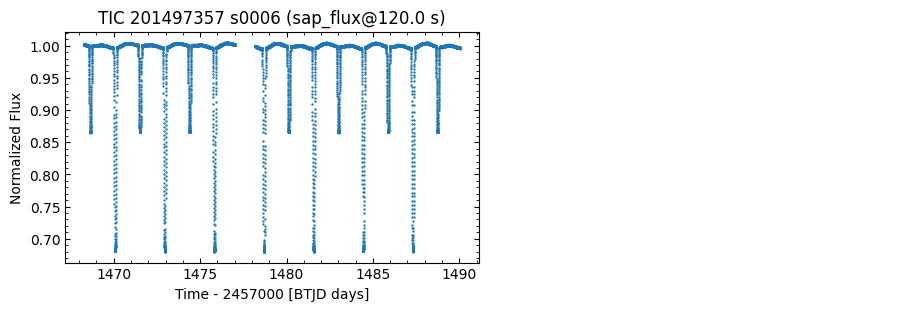

In [10]:
lcs_titles = [f"{target} s{l.sector:04d} ({l.meta['FLUX_ORIGIN']}@{l.meta['FRAMETIM']*l.meta['NUM_FRM']} s)" for l in lcs]
plt.show(fig := plots.plot_lightcurves(lcs, "flux", lcs_titles, normalize_lcs=True))
plt.close(fig)

### Process the light curves to create flattened copies with delta_mag columns

First we select regions to exclude from processing. These could be distorted regions of the
light curve, incomplete eclipses or isolated regions with no useful data. Currently there is
no tool for selecting ranges from the light curve plot directly, so instead we parse the text
of an exclude list of (from, to) time tuples taken from all sectors. For example;
```python
[(1420.0, 1424.0), (2158.0, 2160.0)]
```
where the time values are interpreted with the time format and scale of each light curve.

Once we have any time masks we can use these, along with a simple mask which excludes
invalid flux values, to create masked copies of the original light curves. The masked
light curves are then extended with `delta_mag` and `delta_mag_err` columns calculated
from the fluxes. The `delta_mag` values are detrended and rectified in contiguous segments,
which are selected by finding gaps in the timeseries > gap threshold. Each segment is
rectified and detrended by subtracting a fitted polynomial of the selected degree. 

In [11]:
display(VBox(children=[
    (combine_sectors := Checkbox(description=f"Combine {num_sectors} sector(s)", value=False, indent=False, layout={"width": "25%"}, style={'description_width': 'max-content'})),
    (time_masks_text := Text(description="Time ranges to exclude:", placeholder="[(from, to), (from, to), ...]", layout={'width': "50%"}, style={'description_width': 'max-content'})),
    (seg_gap_th := FloatLogSlider(description="segment gap threshold (d):", base=10, value=2.0, min=-1, max=3, layout={"width": "25%"}, style={'description_width': 'max-content'})),
    HBox(children=[
        (poly_degr := IntSlider(description="detrend poly degree:", value=1, min=1, max=4, layout={"width": "25%"}, style={'description_width': 'max-content'})),
        (dtrd_iters := IntSlider(description="detrend iterations:", value=2, min=1, max=4, layout={"width": "25%"}, style={'description_width': 'max-content'})),
])]))

In [12]:
time_mask_list = []
if len(time_masks_text.value.strip()): # Interpret the list of (from, to) tuples entered above
    time_mask_list = literal_eval(time_masks_text.value)
    if isinstance(time_mask_list, (tuple, int, float)):
        time_mask_list = [time_mask_list]

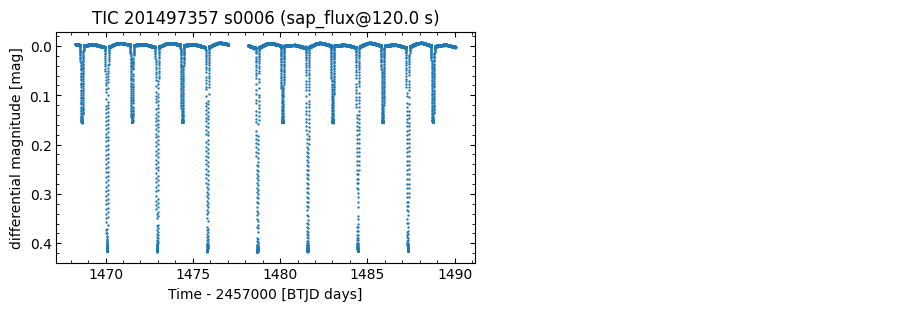

In [13]:
mag_lcs = lk.LightCurveCollection([])
if combine_sectors.value and len(lcs):
    _norm_lcs = [lcs.stitch(lambda lc: lc.normalize())]
    lcs_titles = [f"{target} over {num_sectors} sector(s)"]
else:
    _norm_lcs = (lc.normalize() for lc in lcs)
    
for norm_lc in _norm_lcs:
    # Mask out any invalid fluxes and requested time ranges
    qual_mask = lightcurves.create_invalid_flux_mask(norm_lc)
    for time_mask_range in (lightcurves.to_lc_time(t, norm_lc) for t in time_mask_list):
        qual_mask &= (norm_lc.time < np.min(time_mask_range)) | (norm_lc.time > np.max(time_mask_range))
    norm_lc = norm_lc[qual_mask]

    # Create detrended & rectified delta_mag and delta_mag err columns
    lightcurves.append_magnitude_columns(norm_lc, "delta_mag", "delta_mag_err")
    for s in lightcurves.find_lightcurve_segments(norm_lc, threshold=seg_gap_th.value * u.d):
        norm_lc[s]["delta_mag"] -= lightcurves.fit_polynomial(norm_lc.time[s], norm_lc[s]["delta_mag"],
                                                              poly_degr.value, dtrd_iters.value, 1.0)
    mag_lcs.append(norm_lc)
del _norm_lcs

plt.show(fig := plots.plot_lightcurves(mag_lcs, "delta_mag", lcs_titles))
plt.close(fig)

### Review phase folded light curves
First we lookup for the system's ephemeris in the TESS-ebs catalogue based on its TIC. If nothing found then the primary epoch and orbital period must be set manually by inspecting the light curves above.

By default the T0 time is expected to be the time of a primary eclipse. The phase folded light curves will be phase normalized when folded about this point (which becomes phase 0).

In [14]:
default_t0, default_period = None, None
if (result := tess_ebs_catalog.query_object(mag_lcs[0].meta["OBJECT"])):
    default_t0, default_period = result[0]["BJD0"][0], result[0]["Per"][0]
elif (result := gaia_tbosb_catalog.query_object(search_term)):
    default_period = result[0]["Per"][0]

display(HBox(children=[
    (t0_text := FloatText(description="Primary epoch (btjd):",  value=default_t0, style={'description_width': 'max-content'})),
    (period_text := FloatText(description="Orbital period (d):", value=default_period, style={'description_width': 'max-content'})),
    (double_check := Checkbox(description="Use orbital period x2", value=False, style={"description_width": "max-content"})),
]))

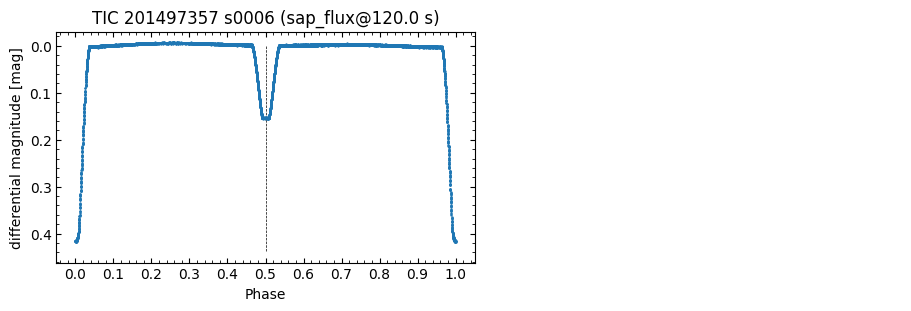

In [15]:
t0 = lightcurves.to_lc_time(t0_text.value, mag_lcs[0])
period = (2 if double_check.value else 1) * (period_text.value * u.d)

def _format_phases(_, ax):
    ax.vlines([0.5], 0, max(ax.get_ylim()), "k", "--", lw=0.5, zorder=-10)
    ax.set_xticks(np.arange(0.0, 1.1, 0.1))

fig = plots.plot_lightcurves([*(lc.fold(period, t0, wrap_phase=u.Quantity(1), normalize_phase=True) for lc in mag_lcs)],
                             "delta_mag", lcs_titles, ax_func=_format_phases)
plt.show(fig)
plt.close(fig)

### Create sampled, phase folded mags data for use with EBOP MAVEN
We now need to make sampled copies of phase folded & phase normalized light curves for
each sector. The EBOP MAVEN model will tell us what wrap it expects for the folded light curves
for estimations through its `mags_feature_wrap_phase` attribute. This will have a value between
0 and 1, or `None`;
- a numeric value indicates the fixed phase above which phased data is expected to be wrapped
to a negative phase
    - a value of 0.75 indicates a phase range of -0.24999 to 0.75, centred on phase 0.25
- a value of `None` indicates the wrap is to ensure the resulting data is centred on the
mid-point between the primary and secondary eclipse
    - in this case the value is calculated from the phase of the secondary eclipse
    which can be set below

In [16]:
if estimator.mags_feature_wrap_phase is None:
    display(HBox(children=[
        (phiS_slider := FloatSlider(description="Phase of secondary eclipse:", value=.5, min=.01, max=.99, step=.01,
                                    layout={"width": "33%"}, style={'description_width': 'max-content'})),
    ]))

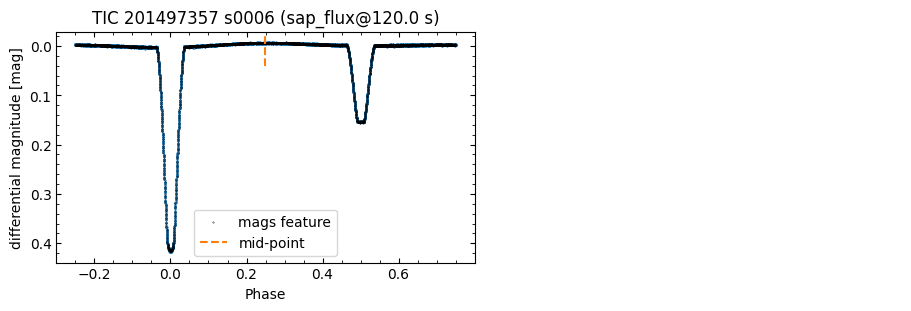

In [17]:
mags_bins = estimator.mags_feature_bins
wrap_phase = u.Quantity(estimator.mags_feature_wrap_phase or (0.5 + phiS_slider.value / 2))

flcs = []
samp_mags = np.zeros(shape=(len(mag_lcs), 2, mags_bins), dtype=np.float32)
for ix, lc in enumerate(mag_lcs):
    flcs.append(flc := lc.fold(period, t0, wrap_phase=wrap_phase, normalize_phase=True))
    samp_mags[ix] = lightcurves.get_sampled_phase_mags_data(flc, mags_bins, wrap_phase)

def _sample_and_mid(ix, ax):
    ax.scatter(samp_mags[ix, 0], samp_mags[ix, 1], s=0.33, c="k", marker=".", label="mags feature")
    ax.vlines(0.5, 0.85, 1, "tab:orange", "--", lw=1.5, transform=ax.transAxes, label="mid-point")

fig = plots.plot_lightcurves(flcs, "delta_mag", lcs_titles, ax_func=_sample_and_mid, legend_loc="lower center")
plt.show(fig)
plt.close(fig)

### Estimate fitting input parameters with EBOP MAVEN
The EBOP MAVEN model will predict values for $r_{\rm A}+r_{\rm B}$, $k$, $J$, $e\cos{\omega}$,
$e\sin{\omega}$ and $b_{\rm P}$ for use as `JKTEBOP` fitting input parameters. To these we will
need to add values for $i$, which can be calculated from the 6 predicted values.

In [18]:
predictions = estimator.predict(samp_mags[:, 1], iterations=1000)
predictions = pipeline.append_calculated_inc_predictions(predictions, "inc")

for lc, preds in zip(mag_lcs, predictions):
    print(f"\nJKTEBOP input parameters for {target} sector {lc.meta['SECTOR']}")
    print(*(f"{p:>12s}: {preds[p] or 0:11.6f}" for p in predictions.dtype.names), sep="\n")


JKTEBOP input parameters for TIC 201497357 sector 6
  rA_plus_rB:    0.232520+/-   0.006800
           k:    0.576124+/-   0.017941
           J:    0.436709+/-   0.035016
       ecosw:    0.001993+/-   0.005530
       esinw:   -0.007902+/-   0.016828
          bP:    0.221056+/-   0.024312
         inc:   88.145818+/-   0.214388


/home/steveo/projects/main/platodebcat/.platodebcat/lib/python3.11/site-packages/numpy/core/_methods.py:99: FutureWarning: AffineScalarFunc.__le__() is deprecated. It will be removed in a future release.
  return um.clip(a, min, max, out=out, **kwargs)
/home/steveo/projects/main/platodebcat/.platodebcat/lib/python3.11/site-packages/numpy/core/_methods.py:99: FutureWarning: AffineScalarFunc.__ge__() is deprecated. It will be removed in a future release.
  return um.clip(a, min, max, out=out, **kwargs)


### Estimate limb darkening parameters
We have starting effective temperature and surface gravity values in the
TESS metadata stored with the light curves, however this refers to system
as a whole. We use J as a simple proxy for the ratio of effective temperatures.

In [19]:
J = np.mean(predictions["J"]).nominal_value
_sys_teff = mag_lcs[0].meta.get("TEFF", 5800) or 5800
_logg = mag_lcs[0].meta.get("LOGG", 4.0) or 4.0
_teff = (_sys_teff, _sys_teff * J) if J < 1 else (_sys_teff / J, _sys_teff)
display(VBox(children=[
    HBox(children=[
        (teffA_text := FloatSlider(description="Effective temp star A (K):", value=_teff[0], min=2300, max=12000, layout={"width": "25%"}, style={'description_width': 'max-content'})),
        (loggA_text := FloatSlider(description="log(g) star A (dex):", value=_logg, min=2.5, max=6.0, step=0.5, style={'description_width': 'max-content'})),    
    ]),
    HBox(children=[
        (teffB_text := FloatSlider(description="Effective temp star B (K):", value=_teff[1], min=2300, max=12000, layout={"width": "25%"}, style={'description_width': 'max-content'})),
        (loggB_text := FloatSlider(description="log(g) star A (dex):", value=_logg, min=2.5, max=6.0, step=0.5, style={'description_width': 'max-content'})),
    ]),
]))

In [20]:
ldA_coeffs = limb_darkening.lookup_pow2_coefficients(loggA_text.value, teffA_text.value)
ldB_coeffs = limb_darkening.lookup_pow2_coefficients(loggB_text.value, teffB_text.value)
ld_params = {
    "LDA": "pow2", "LDA1": ldA_coeffs[0], "LDA2": ldA_coeffs[1],
    "LDB": "pow2", "LDB1": ldB_coeffs[0], "LDB2": ldB_coeffs[1],
}

### Perform JKTEBOP Task 3 analysis
First we set up the in and dat files for each analysis to be run.

In [21]:
# Superset of all of the potentially fitted parameters
all_fitted_params = ["rA_plus_rB", "k", "J", "ecosw", "esinw", "inc", "L3", "pe", "period", "rA", "rB", "LA", "LB", "light_ratio"]
fitted_params = np.empty(shape=(len(mag_lcs), ),
                         dtype=[(k, np.dtype(UFloat.dtype)) for k in all_fitted_params])

In [22]:
task = 3
fit_dir = jktebop.get_jktebop_dir()
file_fmt = f"quick-fit-{target_file_stem}-{{sector:04d}}.{{ext:s}}"
for ix, (lc, preds) in enumerate(zip(mag_lcs, predictions)):
    in_fname = fit_dir / file_fmt.format(sector=lc.meta['SECTOR'], ext="in")
    dat_fname = fit_dir / file_fmt.format(sector=lc.meta['SECTOR'], ext="dat")
    par_fname = fit_dir / file_fmt.format(sector=lc.meta['SECTOR'], ext="par")

    in_params = {
        "task": task,
        "qphot": preds["k"]**1.4,
        "gravA": 0.,                "gravB": 0.,
        "L3": 0.,

        "reflA": 0.,                "reflB": 0.,
        "period": period.value,
        "primary_epoch": t0.value,
        
        "simulations": 100 if task == 8 else "",

        "qphot_fit": 0,
        "ecosw_fit": 1,             "esinw_fit": 1,
        "gravA_fit": 0,             "gravB_fit": 0,
        "L3_fit": 1,
        "LDA1_fit": 1,              "LDB1_fit": 1,
        "LDA2_fit": 0,              "LDB2_fit": 0,
        "reflA_fit": 1,             "reflB_fit": 1,
        "sf_fit": 1,
        "period_fit": 1,            "primary_epoch_fit": 1,

        "data_file_name": dat_fname.name,
        "file_name_stem": dat_fname.stem,

        **{ n: preds[n] for n in preds.dtype.names },
        **ld_params,
    }

    # JKTEBOP will fail if it finds files from a previous fitting
    for file in fit_dir.glob(file_fmt.format(sector=lc.meta["SECTOR"], ext="*")):
        file.unlink()
    segments = lightcurves.find_lightcurve_segments(lc, 0.5, yield_times=True)
    append_lines = jktebop.build_poly_instructions(segments, "sf", 1) + ["", "chif", ""]
    jktebop.write_in_file(in_fname, append_lines=append_lines, **in_params)
    jktebop.write_light_curve_to_dat_file(lc, dat_fname)

    # Blocks on the JKTEBOP task until we can parse the newly written par file contents
    # to read out the revised values for the superset of potentially fitted parameters.
    pgen = jktebop.run_jktebop_task(in_fname, par_fname, stdout_to=sys.stdout)
    for k, v in jktebop.read_fitted_params_from_par_lines(pgen, all_fitted_params, True).items():
        fitted_params[ix][k] = v

  
JKTEBOP  v44  John Southworth (Keele University, UK, taylorsouthworth~gmail.com)
Task 3  finds the best fit of the model to observations  (formal errorbars only)
>> Read parameters for polynomial  1, to be applied to parameter "sf" over a given time interval
>> Read parameters for polynomial  2, to be applied to parameter "sf" over a given time interval
>> Opened new parameter  file:  quick-fit-tic-201497357-0006.par                  
>> Opened new LC output  file:  quick-fit-tic-201497357-0006.out                  
>> Opened new model fit  file:  quick-fit-tic-201497357-0006.fit                  
>> Read  14588 datapoints (with errors) from file quick-fit-tic-201497357-0006.dat                  
>> Read  2 polynomial datasets from the input file
>> Best fit has been found after 24 iterations.
>> Done iteration 1 to adjust errorbars. Chisqred values:  11.526 
>> Done iteration 2 to adjust errorbars. Chisqred values:   1.000 
>> Best fit has been found after 12 iterations.
  


/home/steveo/projects/main/platodebcat/.platodebcat/lib/python3.11/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


#### Report of JKTEBOP fitting results

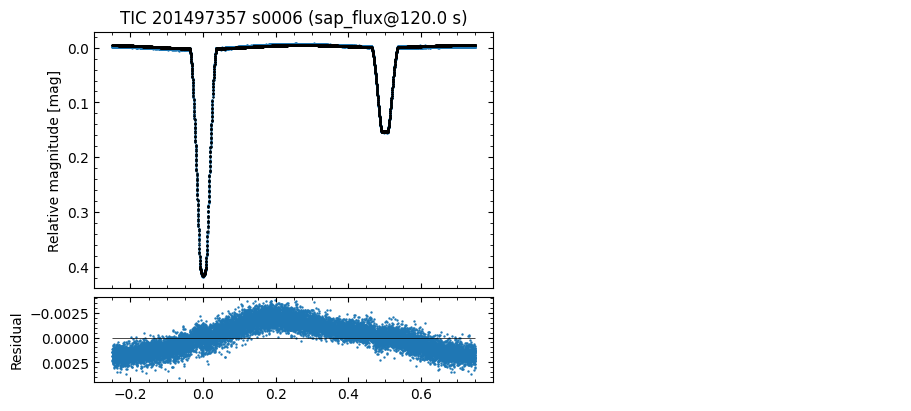

In [23]:
if task == 3:
    rows, cols = int(np.ceil(len(mag_lcs) / 2)), 2
    fig, axes = plt.subplots(rows*2, cols, figsize=(4.5*cols, 4*rows), height_ratios=(3, 1)*rows, constrained_layout=True)

    for ix in range(axes.size//2):
        row, col = int(np.floor(ix / cols) * 2), ix % cols
        ax_lc, ax_res = axes[row, col], axes[row+1, col]
        if ix < len(mag_lcs):
            # Pick columns so they are ordered [phase, lc_mag, model_mag, residual]
            out_file = fit_dir / file_fmt.format(sector=mag_lcs[ix].meta['SECTOR'], ext="out")
            out_data = np.loadtxt(out_file, float, comments="#", usecols=[3, 1, 4, 5], unpack=True)
            out_data[0][out_data[0] > wrap_phase.value] -= 1. # matches wrap used previously
        
            if ix < len(mag_lcs):
                ax_lc.scatter(out_data[0], out_data[1], s=2.0, marker=".", label=None)
                ax_lc.scatter(out_data[0], out_data[2], s=0.5, c="k", marker=".", label=None)
                ax_res.scatter(out_data[0], out_data[3], s=2.0, marker=".", label=None)
                ax_res.hlines([0.0], min(out_data[0]), max(out_data[0]), ls="-", color="k", lw=.5)

                if ix == 0:
                    ax_lc.invert_yaxis()
                    ax_res.invert_yaxis()
                else:
                    ax_lc.sharey(axes[0, 0])
                    ax_res.sharey(axes[1, 0])
        
                # Hides tick labels on inner facing shared axes
                plt.setp(ax_lc.get_xticklabels(), visible=False) 
                if col > 0:
                    plt.setp(ax_lc.get_yticklabels(), visible=False)
                    plt.setp(ax_res.get_yticklabels(), visible=False)
                plots.format_axes(ax_lc, title=lcs_titles[ix], ylabel="" if ix % cols else "Relative magnitude [mag]")
                plots.format_axes(ax_res, ylabel="" if ix % cols else "Residual")
        else:
            ax_lc.axis("off")
            ax_res.axis("off")
    plt.show(fig)
    plt.close(fig)

In [24]:
print(("Mean f" if len(fitted_params) > 1 else "F") + f"itted parameter values for {target} over {num_sectors} sector(s)")
for param in fitted_params.dtype.names:
    print(f"{param:>14s}: {fitted_params[param].mean():12.6f}")

Fitted parameter values for TIC 201497357 over 1 sector(s)
    rA_plus_rB:     0.231345+/-    0.000096
             k:     0.582967+/-    0.001859
             J:     0.474794+/-    0.003910
         ecosw:     0.000186+/-    0.000015
         esinw:     0.001110+/-    0.000696
           inc:    87.926832+/-    0.039434
            L3:     0.003777+/-    0.004749
            pe:  1470.082143+/-    0.000018
        period:     2.872135+/-    0.000005
            rA:     0.146147+/-           0
            rB:     0.085199+/-           0
            LA:     0.861021+/-           0
            LB:     0.135202+/-           0
   light_ratio:     0.157025+/-           0


### Load our support data for MCMC fitting the target's SED

In [25]:
# Extinction model: G23 (Gordon et al., 2023) Milky Way R(V) filter gives us the broadest coverage
ext_model = G23(Rv=3.1)
ext_wl_range = np.reciprocal(ext_model.x_range) * u.um # x_range has implicit units of 1/micron
print(f"Using the {ext_model.__class__.__name__} extinction model which covers the range from",
      f"{min(ext_wl_range)} to {max(ext_wl_range)}.")

Using the G23 extinction model which covers the range from 0.0912 um to 32.0 um.


The NewEra data file publishes spectra previously prepared by the `newera_spectra_to_interp3d.py`
module. These data are in a form suitable for use with the scipy `RegularGridInterpolator` class,
with 3 'points' axes of $i=T_{\rm eff}$, $j=\log{(g)}$ and $k=\nu$ (published as 1d numpy arrays
named `teffs`, `loggs` and `freqs`) covering the flux data (in a 3d array named `V`).

In [26]:
spec_data = np.load("libs/data/newera/PHOENIX-NewEra-for-interp3d.npy.npz", allow_pickle=True)
interp3d = RegularGridInterpolator(points=(spec_data["teffs"], spec_data["loggs"], spec_data["freqs"]),
                                   values=spec_data["V"])

ne_teff_range = (spec_data["teffs"].min(), spec_data["teffs"].max()) * u.K
ne_logg_range = (spec_data["loggs"].min(), spec_data["loggs"].max()) * u.dex
ne_wl_range = c * 1e6 / (spec_data["freqs"].max(), spec_data["freqs"].min()) * u.um
print(f"Loaded previously built 3d dataset of Z=0 NewEra spectra covering the ranges:")
print(f"wavelength={ne_wl_range}, Teff={ne_teff_range} and logg={ne_logg_range}")
del spec_data

Loaded previously built 3d dataset of Z=0 NewEra spectra covering the ranges:
wavelength=[1.000e-02 2.999e+01] um, Teff=[ 2300. 12000.] K and logg=[0.5 6. ] dex


The MIST isochrones are used to get $R$, $T_{\rm eff}$ and $\log{(g)}$ values for given stellar
mass and age combinations. The radii are evaluated against the $k$ prior, and the $T_{\rm eff}$
and $\log{(g)}$ values are the parameters required to generate synthetic spectra for fitting.

In [27]:
# To reduce the number of variable we assume solar metallicity
mist_isos = MistIsochrones(metallicities=[0])

Reading in: /home/steveo/projects/main/platodebcat/libs/data/mist/MIST_v1.2_vvcrit0.4_basic_isos/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.4_basic.iso


### Locate and prepare the target's spectral energy distribution (SED) data
We can query the target's SED with the Vizier SED service which aggregates
flux measurements from various systematic sky surveys. Once we have this
we need to deredden the SED prior to fitting for stellar masses

In [28]:
# Read in the SED for this target
sed = get_sed_for_target(target, search_term, radius=0.1, remove_duplicates=True, verbose=True)

# Filter SED to those covered by our models and also remove any outliers
model_mask = (sed["sed_wl"] >= min(ext_wl_range)) & (sed["sed_wl"] <= max(ext_wl_range)) \
            & (sed["sed_wl"] >= min(ne_wl_range)) & (sed["sed_wl"] <= max(ne_wl_range))
out_mask = sed["sed_filter"] == "HIP:hp"    # These tend to give outliers at ~0.402 um
if "CW Eri" in target:
    out_mask |= sed["sed_filter"] == "Cousins:I"
sed = sed[model_mask & ~out_mask]

Opened SED table tic-201497357-0.1.vot containing 92 row(s).
Removing 46 duplicate row(s).


In [29]:
for val, flags in extinction.get_ebv(target_coords):
    if val and not np.isnan(val) and flags.get("converged", False):
        print(f"Found extinction with {flags['source']}: {flags.get('type', '')} = {val:.6f}")
        sed["sed_der_flux"] = sed["sed_flux"] / ext_model.extinguish(sed["sed_wl"].to(u.um), Ebv=val)
        break

if "sed_der_flux" in sed.colnames:
    der_lab = "dereddened"
else:
    sed["sed_der_flux"] = sed["sed_flux"]
    der_lab = "not dereddened"

sed["sed_vfv"], sed["sed_evfv"] = calculate_vfv(sed, flux_colname="sed_flux")
sed["sed_der_vfv"], sed["sed_der_evfv"] = calculate_vfv(sed, flux_colname="sed_der_flux")

Found extinction with get_gontcharov_ebv: E(B-V) = 0.073242


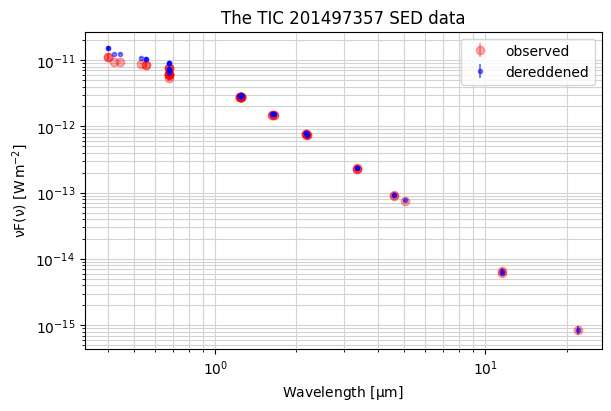

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
ax.errorbar(sed["sed_wl"], sed["sed_vfv"], sed["sed_evfv"], fmt="or", alpha=0.33, label="observed")
ax.errorbar(sed["sed_wl"], sed["sed_der_vfv"], sed["sed_der_evfv"], fmt=".b", alpha=0.5, label=der_lab)
ax.set(title=f"The {target} SED data",
       xscale="log", xlabel=f"Wavelength [{sed['sed_wl'].unit:latex_inline}]",
       yscale="log", ylabel=f"${{\\rm \\nu F(\\nu)}}$ [{sed['sed_der_vfv'].unit:latex_inline}]")
ax.grid(True, which="both", axis="both", color="lightgray")
ax.legend(loc="best")
plt.show(fig)
plt.close(fig)

### Prepare for the MCMC fitting of the SED data

These are options for generating synthetic spectra at a set of given frequencies for chosen
parameters.

In [31]:
from deblib.constants import c, h, k_B
from deblib.vmath import exp
def bb_spec_brightness(freqs, teff, logg):
    """
    Calculate the BB spectral brightness at effective temp T and frequencies nu with;
    B(x, T) = (2h*nu^3)/c^2 * 1/(exp(h*nu/kT)-1)  [W / m^2 / Hz / sr]

    teff and freqs have units of K and Hz, respectively. The logg argument is ignored.
    """
    # pylint: disable=unused-argument
    return ((2 * h * freqs**3) / c**2) / (exp((h * freqs) / (k_B * teff)) - 1)

def newera_spectrum(freqs, teff, logg):
    # We can interpolate for multiple values in one hit;
    # in this case we want multiple frequencies for a single Teff/logg combo
    return interp3d(np.array([[teff, logg, freq] for freq in freqs]), method="linear")

This is the `emcee` prior function which evaluates the current walker position against known priors.

In [32]:
MIN_MASS, MAX_MASS = 0.1, 270.      # realistic MIST mass range
MIN_PHASE, MAX_PHASE = Phase.MS, Phase.MS
mist_ages = mist_isos.list_ages(feh=0, min_phase=MIN_PHASE, max_phase=MAX_PHASE)
MIN_AGE, MAX_AGE = min(mist_ages), max(mist_ages)
MIN_TEFF, MAX_TEFF = ne_teff_range.value
MIN_LOGG, MAX_LOGG = ne_logg_range.value
MIST_PRIOR_PARAMS = ["Teff", "log_g", "R"]

# Target specific priors
k = fitted_params["k"].mean().nominal_value
k_flex = max(k * 0.1, fitted_params["k"].mean().std_dev)
print(f"Priors from LC fitting: k={k:f} +/- flex of {k_flex:f}")

def ln_prior(MA: float, MB: float, age: float):
    """
    The MCMC log prior function which evaluates the properties of the stars defined by
    the current masses and age against known prior constraints.
    """
    # pylint: disable=too-many-locals
    TeffA, TeffB, loggA, loggB = None, None, None, None
    retval = -np.inf # failure

    # Basic validation of priors; lookup won't work if these are out of range of MIST values
    if MIN_MASS <= MA <= MAX_MASS and MIN_MASS <= MB <= MAX_MASS and MIN_AGE <= age <= MAX_AGE:
        try:
            # Get the stellar params to evaluate, plus the Teffs/logg are req'd to generate SEDs
            TeffA, loggA, RA = mist_isos.stellar_params_for_mass(0, age, MA, MIST_PRIOR_PARAMS, MIN_PHASE, MAX_PHASE)
            TeffB, loggB, RB = mist_isos.stellar_params_for_mass(0, age, MB, MIST_PRIOR_PARAMS, MIN_PHASE, MAX_PHASE)

            # Evaluate the stellar params against the priors.
            # In the case of k, ratio of radii, the prior is specific to this target.
            if np.abs((RB / RA) - k) <= k_flex \
                and min(TeffA, TeffB) >= MIN_TEFF and max(TeffA, TeffB) <= MAX_TEFF \
                and min(loggA, loggB) >= MIN_LOGG and max(loggA, loggB) <= MAX_LOGG:
                retval = 0 # params conform to the priors
        except ValueError: # If lookup fails with no match
            pass

    # Return whether the prior eval is good (0) and also the revised theta for use by model_func
    return retval, (TeffA, TeffB, loggA, loggB)

Priors from LC fitting: k=0.582967 +/- flex of 0.058297


#### Perform the MCMC fitting of the SED data

In [33]:
init_MA, init_MB, init_age = 1.0, 1.0, 9.0
print(f"Starting point:\nMA = {init_MA} M_sun\nMB = {init_MB} M_sun\nlog(age) = {init_age}")

Starting point:
MA = 1.0 M_sun
MB = 1.0 M_sun
log(age) = 9.0


In [34]:
nwalkers = 100
niters = 100000

rng = np.random.default_rng(42)
initial = np.array([init_MA, init_MB, init_age])
ndim = len(initial)
p0 = [initial + rng.normal(0, 0.1, ndim) for _ in range(nwalkers)]

# Fitting will be based on a normalized copy of the dereddened fluxes
sed["sed_norm_flux"], sed["sed_norm_eflux"] = mcmc_sed.min_max_normalize(sed["sed_der_flux"].value,
                                                                         sed["sed_eflux"].value)

# These the functions for generating synthetic spectra and combining them into a model
spec_func = newera_spectrum if max(init_MA, init_MB) < 4.0 else bb_spec_brightness
def model_func(x, Teff1, Teff2, logg1, logg2):
    return mcmc_sed.min_max_normalize(np.add(spec_func(x, Teff1, logg1),spec_func(x, Teff2, logg2)))

# These are the "fixed" kwargs which will be sent to the MCMC ln_prob function
kwargs = {
    "x": sed["sed_freq"].value,
    "y": sed["sed_norm_flux"].value,
    "y_err": sed["sed_norm_eflux"].value,
    "ln_prior_func": ln_prior,
    "model_func": model_func
}

In [35]:
with warnings.catch_warnings(category=RuntimeWarning):
    warnings.filterwarnings("ignore") #, message="(?:.*)invalid value encountered in scalar subtract")
    with Pool(processes=None) as pool:
        print(f"Running MCMC for {niters} iterations...")
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_fn=mcmc_sed.ln_prob, kwargs=kwargs, pool=pool)
        state = sampler.run_mcmc(p0, niters, progress=True)

Running MCMC for 100000 iterations...


100%|██████████| 100000/100000 [17:24<00:00, 95.73it/s]


In [36]:
accept_frac = np.mean(sampler.acceptance_fraction)
print(f"Mean Acceptance fraction: {accept_frac:.6f}")

try:
    # autocorrelation time; steps to effectively "forget" start position
    tau = sampler.get_autocorr_time(c=1)
    print(f"Autocorrelation steps:   ", ", ".join(f"{t:.3f}" for t in tau))
except AutocorrError as err:
    print(f"\033[93m\033[1m{err}\033[0m")
    tau = err.tau

Mean Acceptance fraction: 0.144708
Autocorrelation steps:    287.824, 287.548, 285.768


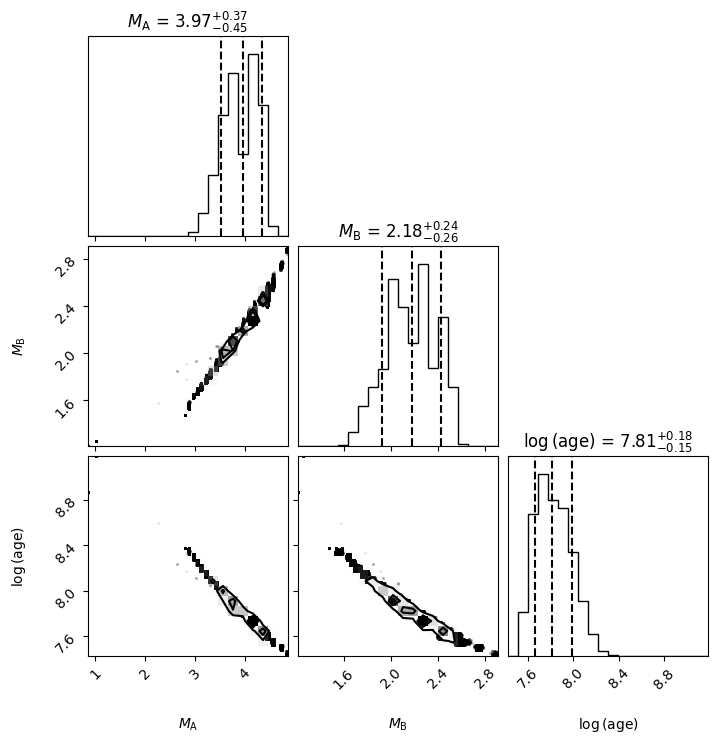

In [37]:
warm_discard = int(np.mean(np.nan_to_num(tau, copy=True, nan=1000))) * 2
thin = max(1, int(1 / (1-max(accept_frac, 0.1))))

# thin; every nth step from the chain
samples = sampler.get_chain(discard=warm_discard, thin=thin, flat=True)
fig = corner.corner(samples, show_titles=True, plot_datapoints=True, quantiles=[0.16, 0.5, 0.84],
                    labels=[r"$M_{\rm A}$", r"$M_{\rm B}$", r"$\log{({\rm age})}$"])
plt.show(fig)
plt.close(fig)

## Characterise the system

In [39]:
from deblib.orbital import semi_major_axis
from deblib.constants import M_sun, R_sun

new_params = ["MA", "MB", "log(age)", "a", "RA", "RB"]
pub_params = np.empty((1,), np.dtype(fitted_params.dtype.descr + [(p, UFloat.dtype) for p in new_params]))
for param in list(set(fitted_params.dtype.names) & set(pub_params.dtype.names)):
    pub_params[param] = fitted_params[param].mean()

# Get the values fitted by MCMC (currently MA, MB and log(age))
# TODO: properly treat asymmetric uncertainties (possibly https://github.com/anisotropela/add_asym)
fitted_vals = np.median(samples, axis=0)
fitted_high = np.quantile(samples, 0.84, axis=0) - fitted_vals
fitted_low = fitted_vals - np.quantile(samples, 0.16, axis=0)
for ix, param in enumerate(["MA", "MB", "log(age)"]):
    pub_params[param] = ufloat(fitted_vals[ix], max(fitted_high[ix], fitted_low[ix]))

a = semi_major_axis(pub_params["MA"] * M_sun, pub_params["MB"] * M_sun, pub_params["period"] * 86400) # m
pub_params["RA"] = (pub_params["rA"] * a) / R_sun
pub_params["RB"] = (pub_params["rB"] * a) / R_sun
pub_params["a"] = a / R_sun

print(f"Final parameter values for {target}")
for param, unit in [("period", u.d), ("a", u.solRad), ("inc", u.deg), ("log(age)", u.dex(u.yr)),
                    ("MA", u.solMass), ("MB", u.solMass), ("RA", u.solRad), ("RB", u.solRad)]:
    print(f"{param:>12s}: {pub_params[param][0]:11.6f} {unit:unicode}")

Final parameter values for TIC 201497357
      period:    2.872135+/-   0.000005 d
           a:   15.580592+/-   0.437781 R☉
         inc:   87.926832+/-   0.039434 °
    log(age):    7.813974+/-   0.177336 dex(yr)
          MA:    3.970232+/-   0.450239 M☉
          MB:    2.181945+/-   0.257331 M☉
          RA:    2.277052+/-   0.063980 R☉
          RB:    1.327446+/-   0.037298 R☉
